In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/Downloads/Log In - AgInjuryNews (1).xlsx - Sheet1 (1) - Log In - AgInjuryNews (1).xlsx - Sheet1 (1).csv')

X = pd.DataFrame(dataset.iloc[:,:18].values)
Y = pd.DataFrame(dataset.iloc[:,18:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
X_train, X_train_val, Y_train, Y_train_val = train_test_split(X,Y,test_size=0.2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.reshape(2735,18,1)
X_test.reshape(684,18,1)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

features = pd.DataFrame(dataset.iloc[:,:18])
features = features.columns
print(features)

      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0      3   2   2  25   0   3  10   0   0   0   0   0   0   0   0   0   1   1
1      3   3   1  61   0   3  10   0   0   0   0   0   0   0   0   0   7   1
2      3   3   1  65   0   3  10   0   0   0   0   0   0   0   0   0   6   1
3      3   2   1  49   0   3  10   0   0   0   1   0   0   0   0   0   5   1
4      3   1   1  54   0   5   2   1   1   0   0   0   0   0   0   1   5   1
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3414   1   2   1  57   0   6   7   0   0   0   0   0   0   0   0   0   1   4
3415   1   1   1  24   0   3   7   0   0   0   0   0   0   0   0   0   1   4
3416   1   1   1  50   0   3  10   0   0   0   0   0   0   0   0   0   6   4
3417   1   2   1  58   0   3   9   0   0   0   0   0   0   0   0   0   6   4
3418   1   2   1   3   0   4  10   0   0   0   0   0   0   0   0   0   5   4

[3419 rows x 18 columns]
      0
0     0
1     1
2     1
3     0
4     1
..

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [3]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=64, step=4)
  model.add(Conv1D(filters=hp_units, kernel_size=3, activation='relu', input_shape=(18, 1)))

  # Max pooling layer
  model.add(MaxPooling1D(pool_size=2))
  hp_units2 = hp.Int('units2', min_value=64, max_value=256, step=16)
  # Second convolutional layer
  model.add(Conv1D(filters=hp_units2, kernel_size=3, activation='relu'))

  # Second max pooling layer
  model.add(MaxPooling1D(pool_size=2))
  hp_units3 = hp.Int('units3', min_value=256, max_value=512, step=32)
  model.add(Conv1D(filters=hp_units3, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  # Flatten the output to feed it into the Dense layer
  model.add(Flatten())

  # Dense layer with dropout for regularization
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(keras.layers.Dense(1))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4,1e-5,1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [4]:
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape = (18,)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [5]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_accuracy',
                     directory='cnn_bayes_opt',
                     project_name='cnn_bayes_opt')


Reloading Tuner from cnn_bayes_opt\cnn_bayes_opt\tuner0.json


In [6]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, Y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 40 and the optimal learning rate for the optimizer
is 0.001.



In [7]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=500, validation_split=0.2)



Epoch 1/500


69/69 [==============================] - 2s 11ms/step - loss: 0.6608 - accuracy: 0.4986 - val_loss: 0.6465 - val_accuracy: 0.6252
Epoch 2/500
69/69 [==============================] - 1s 7ms/step - loss: 0.6492 - accuracy: 0.5704 - val_loss: 0.6344 - val_accuracy: 0.5759
Epoch 3/500
69/69 [==============================] - 0s 7ms/step - loss: 0.6440 - accuracy: 0.5430 - val_loss: 0.6419 - val_accuracy: 0.5046
Epoch 4/500
69/69 [==============================] - 0s 7ms/step - loss: 0.6380 - accuracy: 0.5658 - val_loss: 0.6348 - val_accuracy: 0.5356
Epoch 5/500
69/69 [==============================] - 0s 7ms/step - loss: 0.6349 - accuracy: 0.5736 - val_loss: 0.6360 - val_accuracy: 0.5832
Epoch 6/500
69/69 [==============================] - 0s 7ms/step - loss: 0.6308 - accuracy: 0.5868 - val_loss: 0.6324 - val_accuracy: 0.5558
Epoch 7/500
69/69 [==============================] - 0s 7ms/step - loss: 0.6327 - accuracy: 0.5946 - val_loss: 0.6435 - val_accuracy: 0.5009
Epoch 8/

In [8]:
val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 479


In [9]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train, Y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/479
69/69 [==============================] - 2s 9ms/step - loss: 0.6613 - accuracy: 0.4945 - val_loss: 0.6484 - val_accuracy: 0.5576
Epoch 2/479
69/69 [==============================] - 0s 7ms/step - loss: 0.6461 - accuracy: 0.5631 - val_loss: 0.6530 - val_accuracy: 0.4534
Epoch 3/479
69/69 [==============================] - 0s 6ms/step - loss: 0.6431 - accuracy: 0.5722 - val_loss: 0.6419 - val_accuracy: 0.6453
Epoch 4/479
69/69 [==============================] - 0s 6ms/step - loss: 0.6376 - accuracy: 0.5731 - val_loss: 0.6437 - val_accuracy: 0.6051
Epoch 5/479
69/69 [==============================] - 0s 7ms/step - loss: 0.6311 - accuracy: 0.5818 - val_loss: 0.6384 - val_accuracy: 0.5466
Epoch 6/479
69/69 [==============================] - 0s 7ms/step - loss: 0.6349 - accuracy: 0.5900 - val_loss: 0.6392 - val_accuracy: 0.6088
Epoch 7/479
69/69 [==============================] - 0s 7ms/step - loss: 0.6288 - accuracy: 0.6065 - val_loss: 0.6370 - val_accuracy: 0.5484
Epoch 8/479
6

In [10]:
res = hypermodel.predict(X_test)
res.round()
actual = []
for num in res:
    if num>0.5:
        actual.append(1)
    else:
        actual.append(0)
from sklearn.metrics import classification_report
print(classification_report(Y_test,actual,digits=6))

22/22 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0   0.751004  0.733333  0.742063       255
           1   0.843678  0.855478  0.849537       429

    accuracy                       0.809942       684
   macro avg   0.797341  0.794406  0.795800       684
weighted avg   0.809129  0.809942  0.809470       684



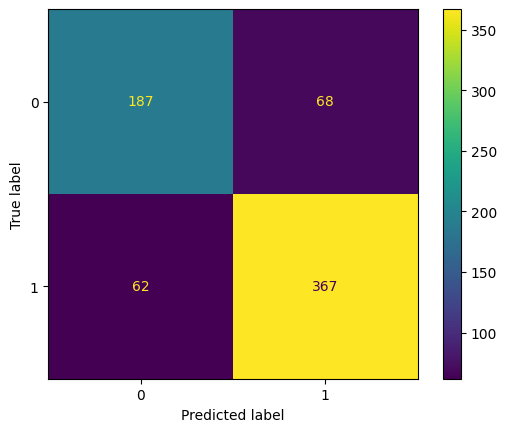

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, actual)
cm_display = ConfusionMatrixDisplay(confusionmatrix, display_labels=[0,1])
cm_display.plot()

In [12]:
import shap
X_test_shap = shap.sample(X_train,nsamples = 300)
explainer = shap.Explainer(model, X_test_shap)
shap_values = explainer.shap_values(X_test_shap)


c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 301it [00:40,  5.97it/s]                         


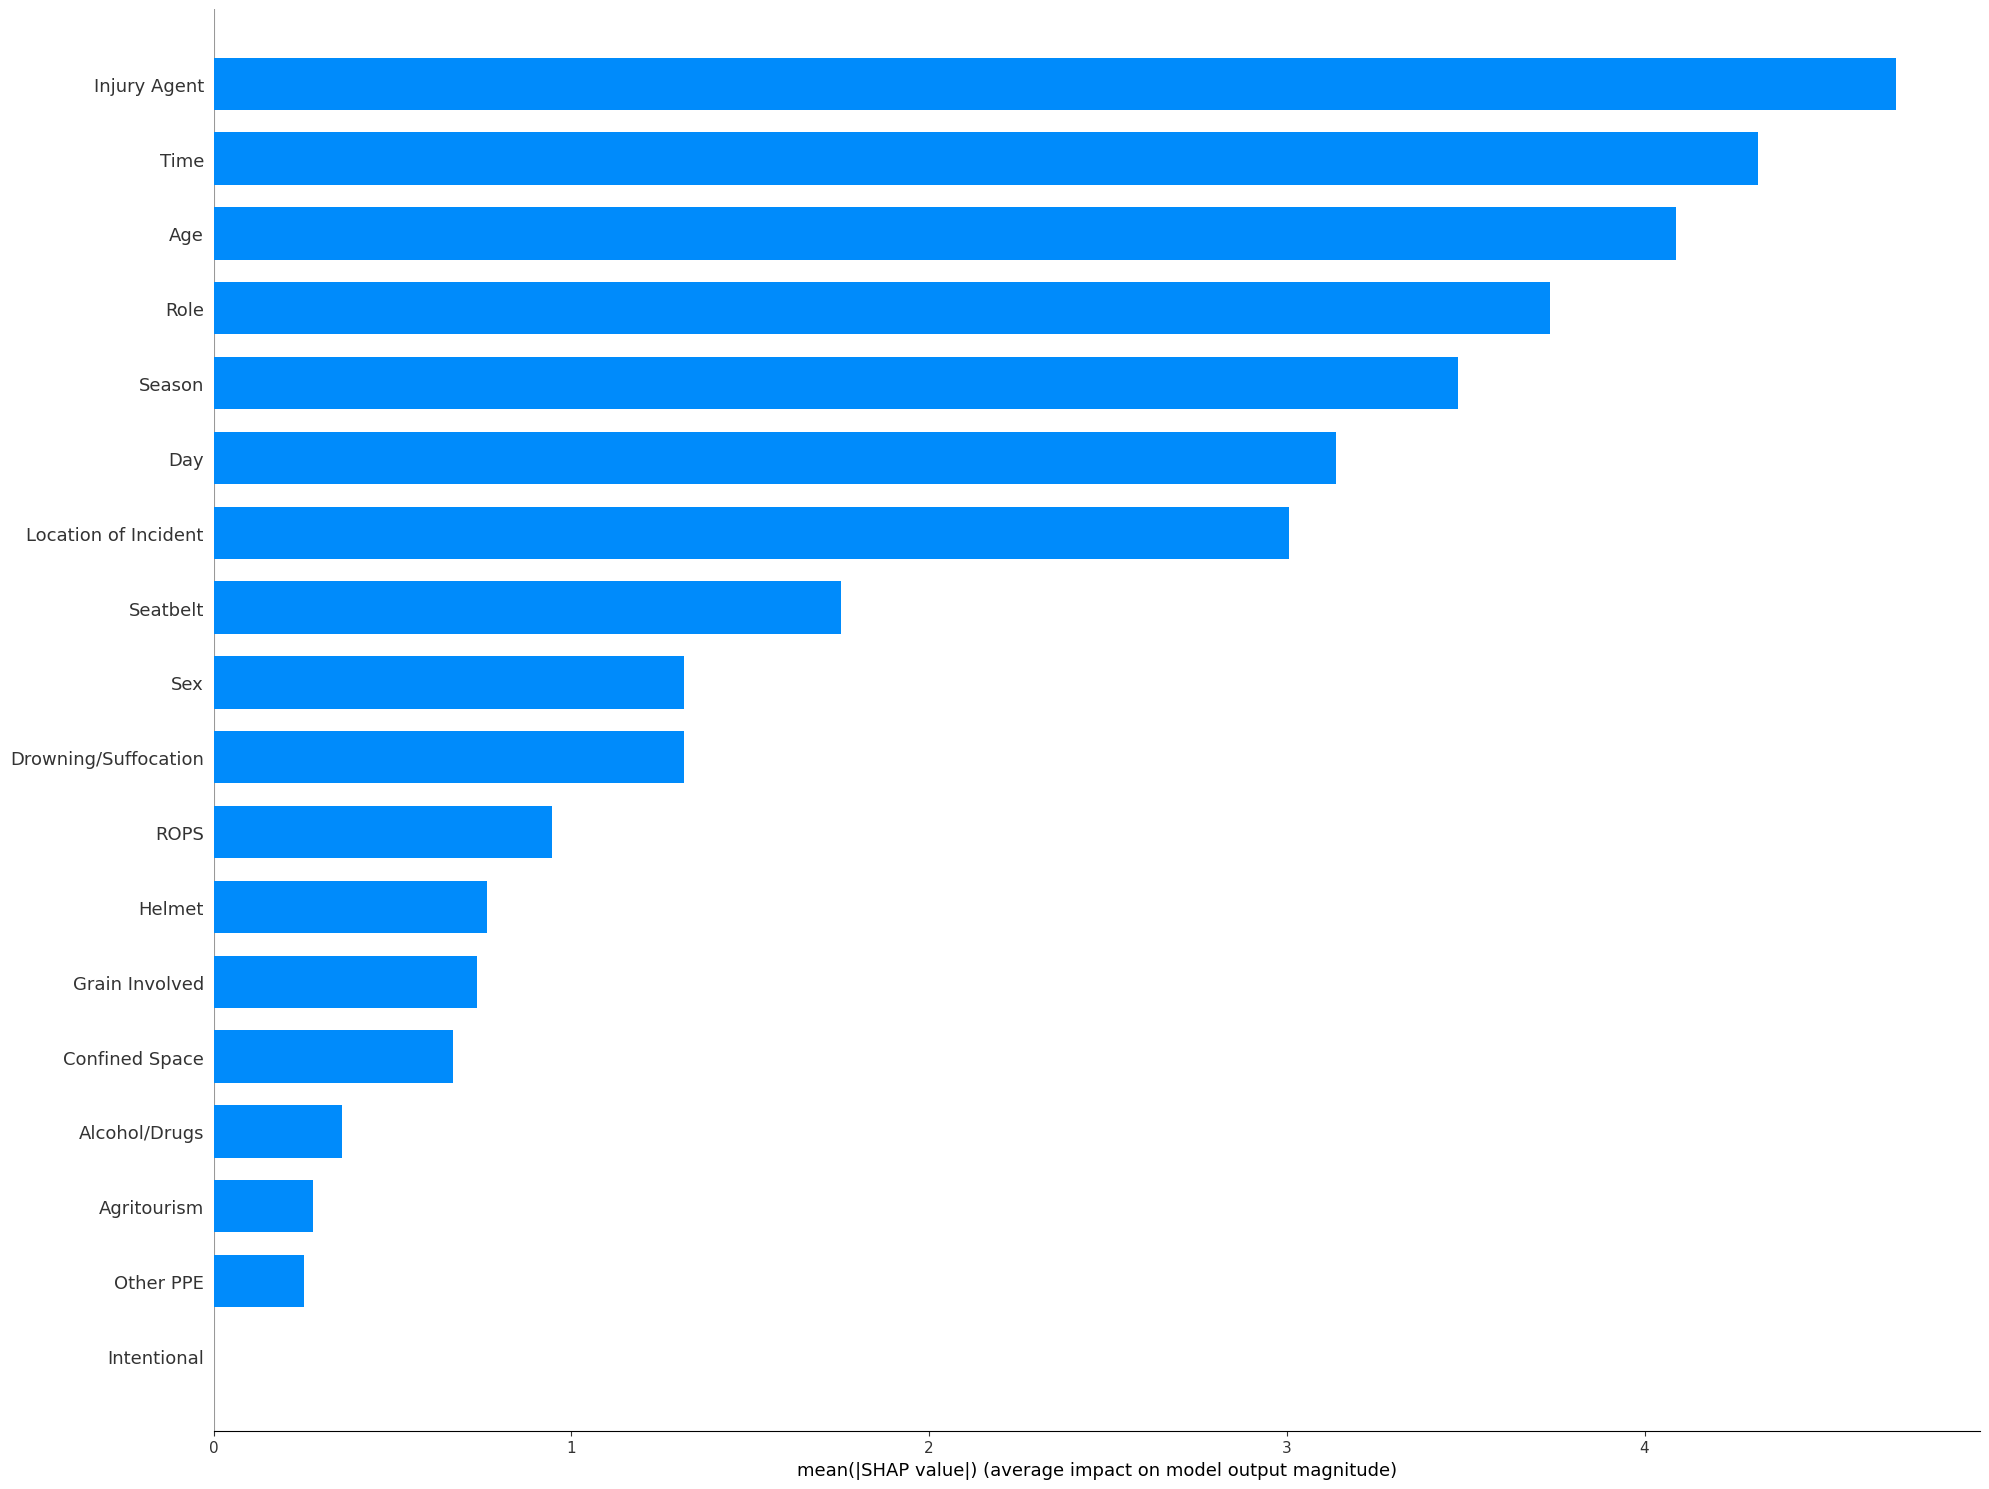

In [13]:
shap.summary_plot(shap_values, feature_names=features, plot_type="bar", plot_size=(20,15))

PermutationExplainer explainer: 301it [01:36,  2.75it/s]                         


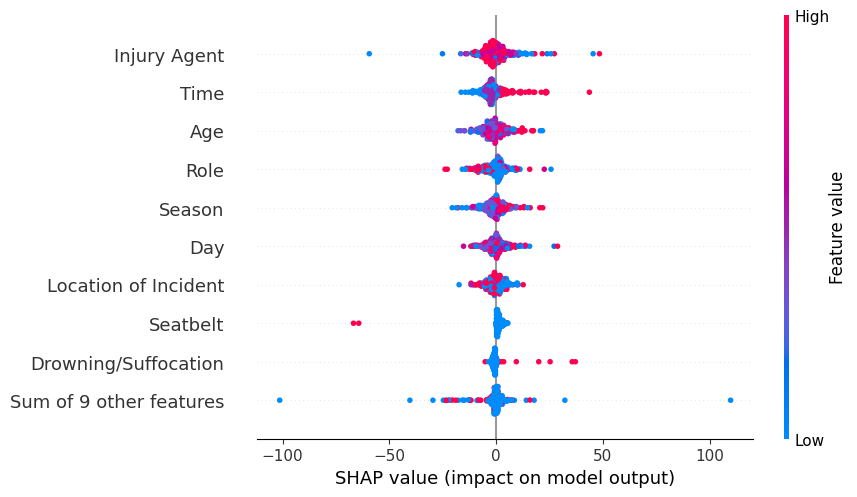

In [15]:
explanation = explainer(X_test_shap)
explanation = shap.Explanation(
    values=explanation, 
    feature_names=features
)
shap.plots.beeswarm(explanation)